## importing the required libraries


In [73]:
import pandas as pd
import numpy as np
from sklearn.metrics import roc_auc_score, log_loss
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import StratifiedKFold
import xgboost as xgb
import catboost as cat_
import seaborn as sns
import lightgbm as lgb
from sklearn.preprocessing import LabelEncoder
import optuna.integration.lightgbm as lgb2
import pickle

## Reading dataset

In [74]:
data = pd.read_csv("../data/fertilizer Prediction.csv")

def data_information(data):
    print('Data Information Table')
    display(data.info(verbose = True,show_counts=True))
    print('\n Data Head Table')
    display(data.head())
    print('\n Data Describe Information Table')
    display(data.describe())
    print(f'\n Data Shape: {data.shape}')
    print(f'\n Data Columns {data.columns}')
    print('\n Data Null item Information Table')
    return

In [75]:
data_information(data)

Data Information Table
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99 entries, 0 to 98
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Temparature      99 non-null     int64 
 1   Humidity         99 non-null     int64 
 2   Moisture         99 non-null     int64 
 3   Soil Type        99 non-null     object
 4   Crop Type        99 non-null     object
 5   Nitrogen         99 non-null     int64 
 6   Potassium        99 non-null     int64 
 7   Phosphorous      99 non-null     int64 
 8   Fertilizer Name  99 non-null     object
dtypes: int64(6), object(3)
memory usage: 7.1+ KB


None


 Data Head Table


,Temparature,Humidity,Moisture,Soil Type,Crop Type,Nitrogen,Potassium,Phosphorous,Fertilizer Name
0,26,52,38,Sandy,Maize,37,0,0,Urea
1,29,52,45,Loamy,Sugarcane,12,0,36,DAP
2,34,65,62,Black,Cotton,7,9,30,14-35-14
3,32,62,34,Red,Tobacco,22,0,20,28-28
4,28,54,46,Clayey,Paddy,35,0,0,Urea



 Data Describe Information Table


,Temparature,Humidity,Moisture,Nitrogen,Potassium,Phosphorous
count,99.000000,99.000000,99.000000,99.000000,99.000000,99.000000
mean,30.282828,59.151515,43.181818,18.909091,3.383838,18.606061
std,3.502304,5.840331,11.271568,11.599693,5.814667,13.476978
min,25.000000,50.000000,25.000000,4.000000,0.000000,0.000000
25%,28.000000,54.000000,34.000000,10.000000,0.000000,9.000000
50%,30.000000,60.000000,41.000000,13.000000,0.000000,19.000000
75%,33.000000,64.000000,50.500000,24.000000,7.500000,30.000000
max,38.000000,72.000000,65.000000,42.000000,19.000000,42.000000



 Data Shape: (99, 9)

 Data Columns Index(['Temparature', 'Humidity ', 'Moisture', 'Soil Type', 'Crop Type',
       'Nitrogen', 'Potassium', 'Phosphorous', 'Fertilizer Name'],
      dtype='object')

 Data Null item Information Table


## Visualisation

In [76]:
def make_pie(feature) :
    sns.set(rc = {'figure.figsize':(30, 20)})
    plt.pie(data[feature].value_counts(),labels=list(data[feature].value_counts().index),
        autopct ='%1.2f%%' , labeldistance = 1.1,explode = [0.05 for i in range(len(data[feature].value_counts()))] )
    plt.show()

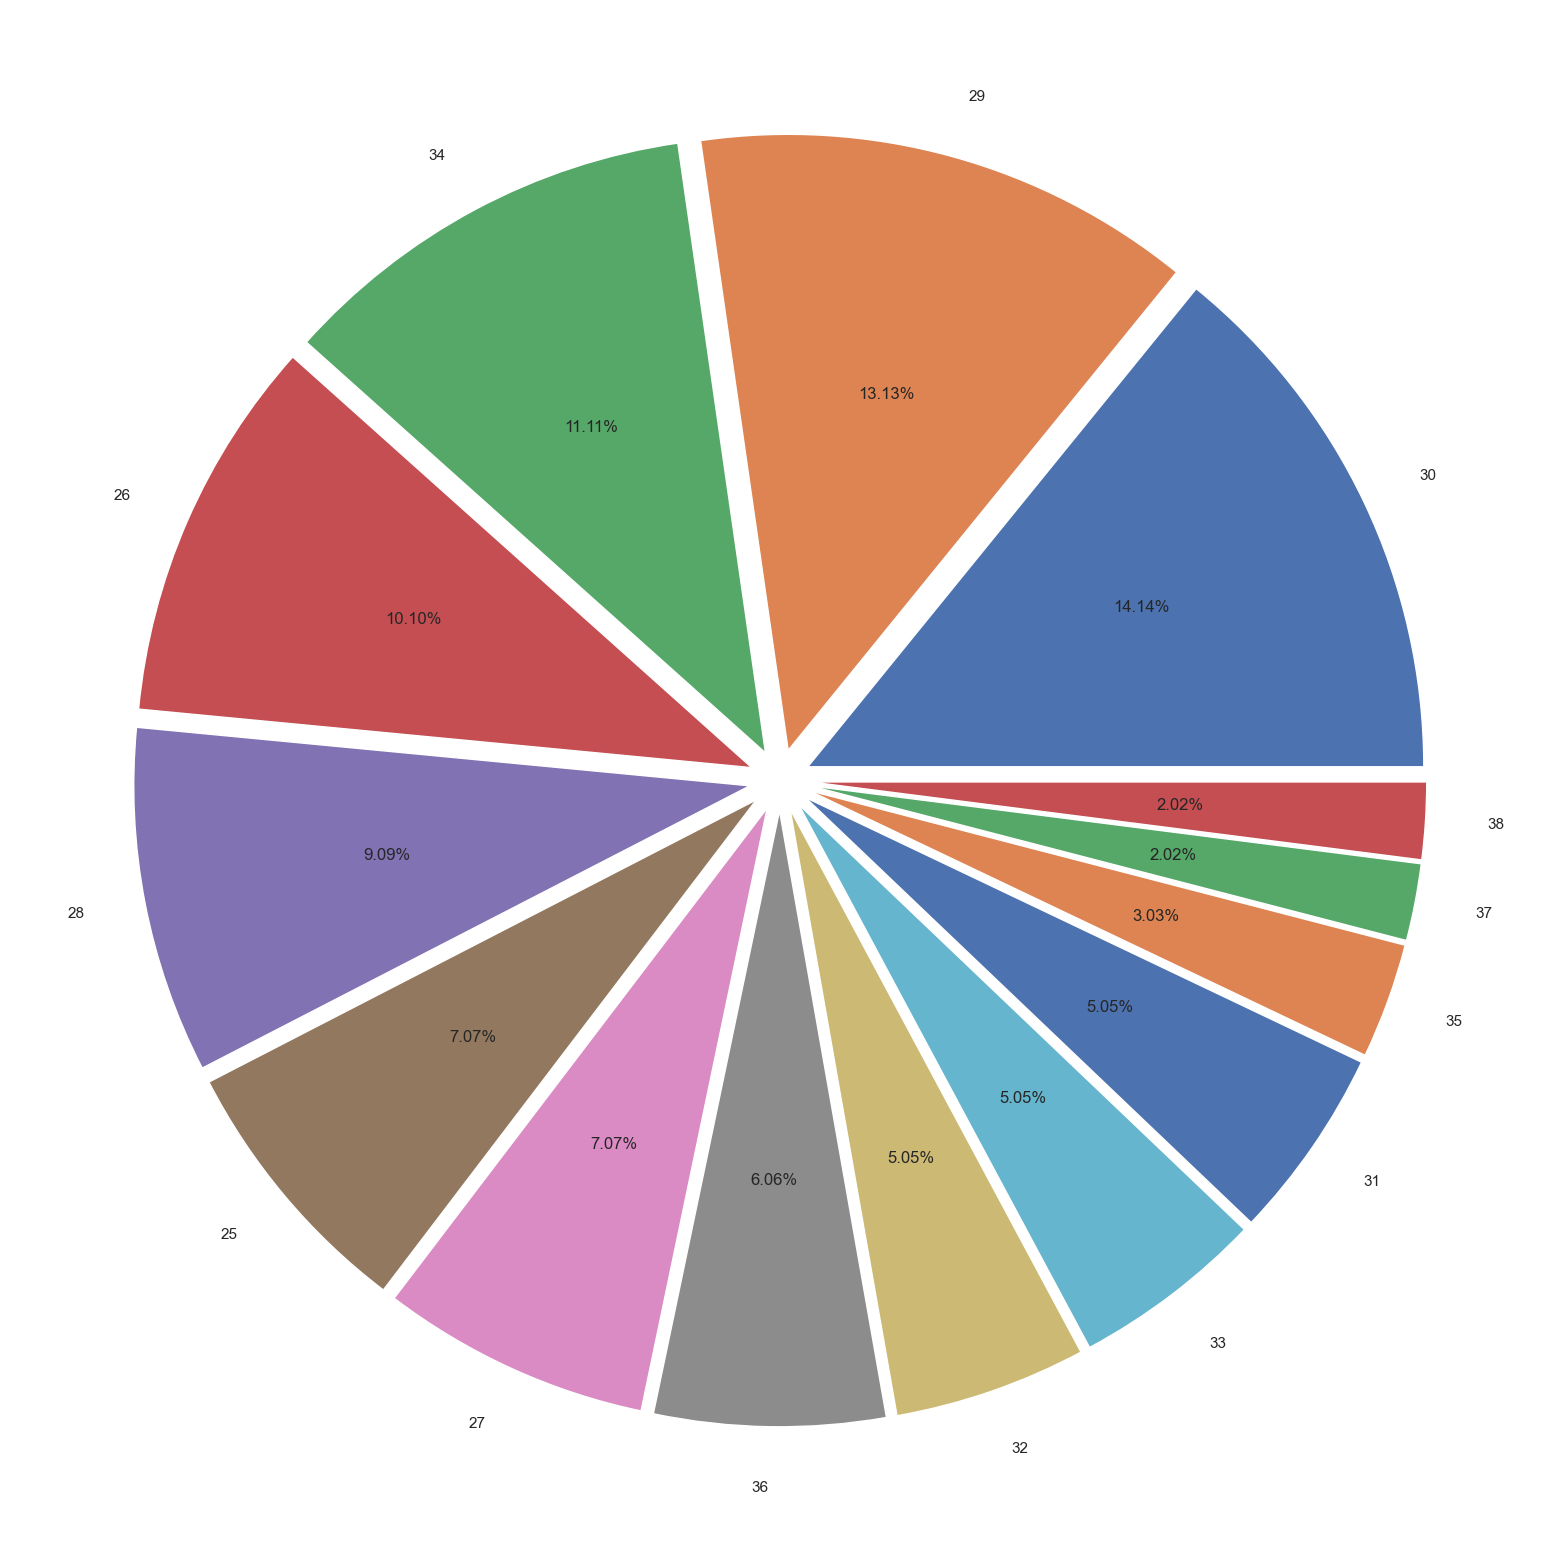

In [77]:
make_pie('Temparature')

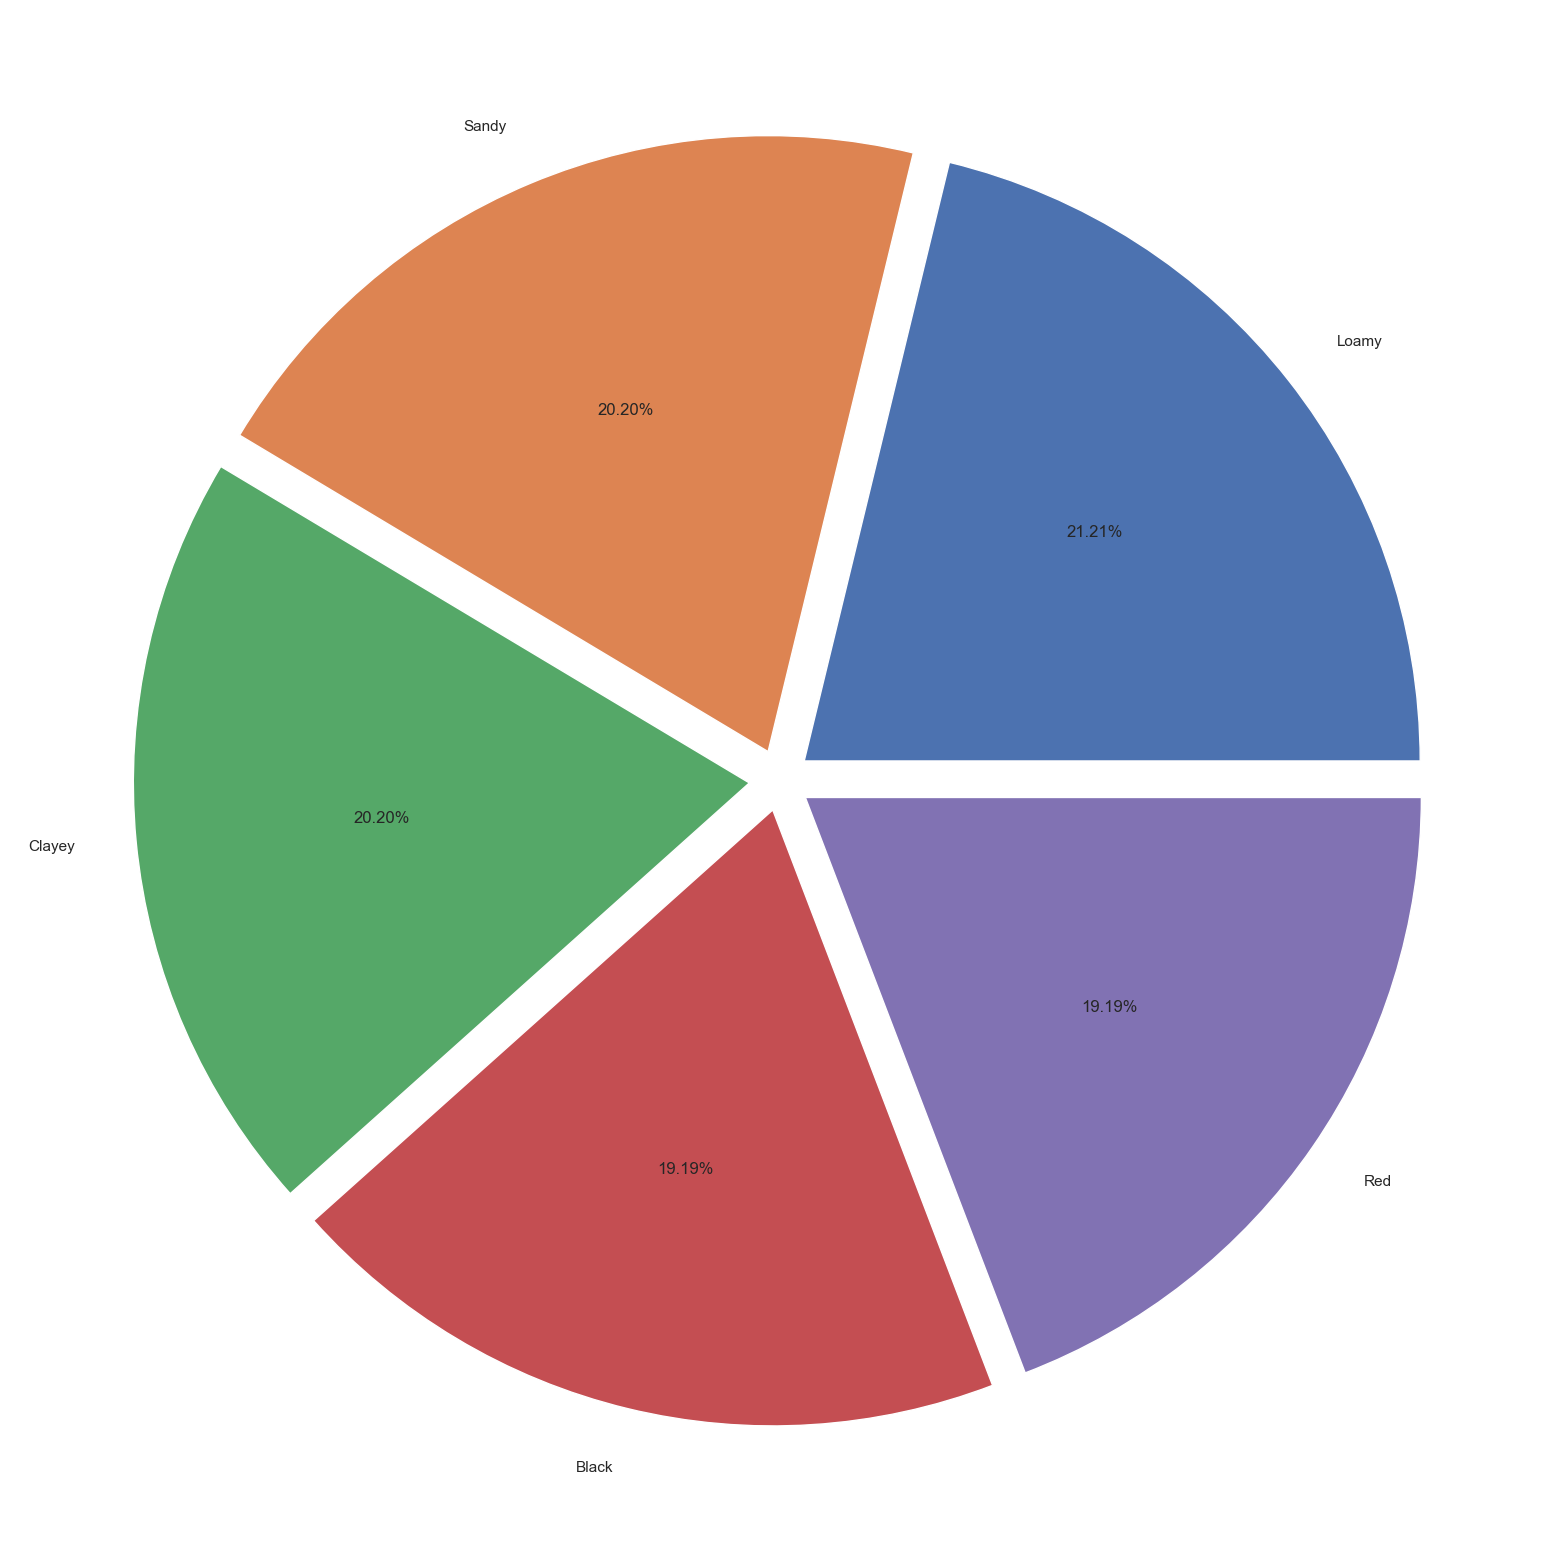

In [78]:
make_pie('Soil Type')

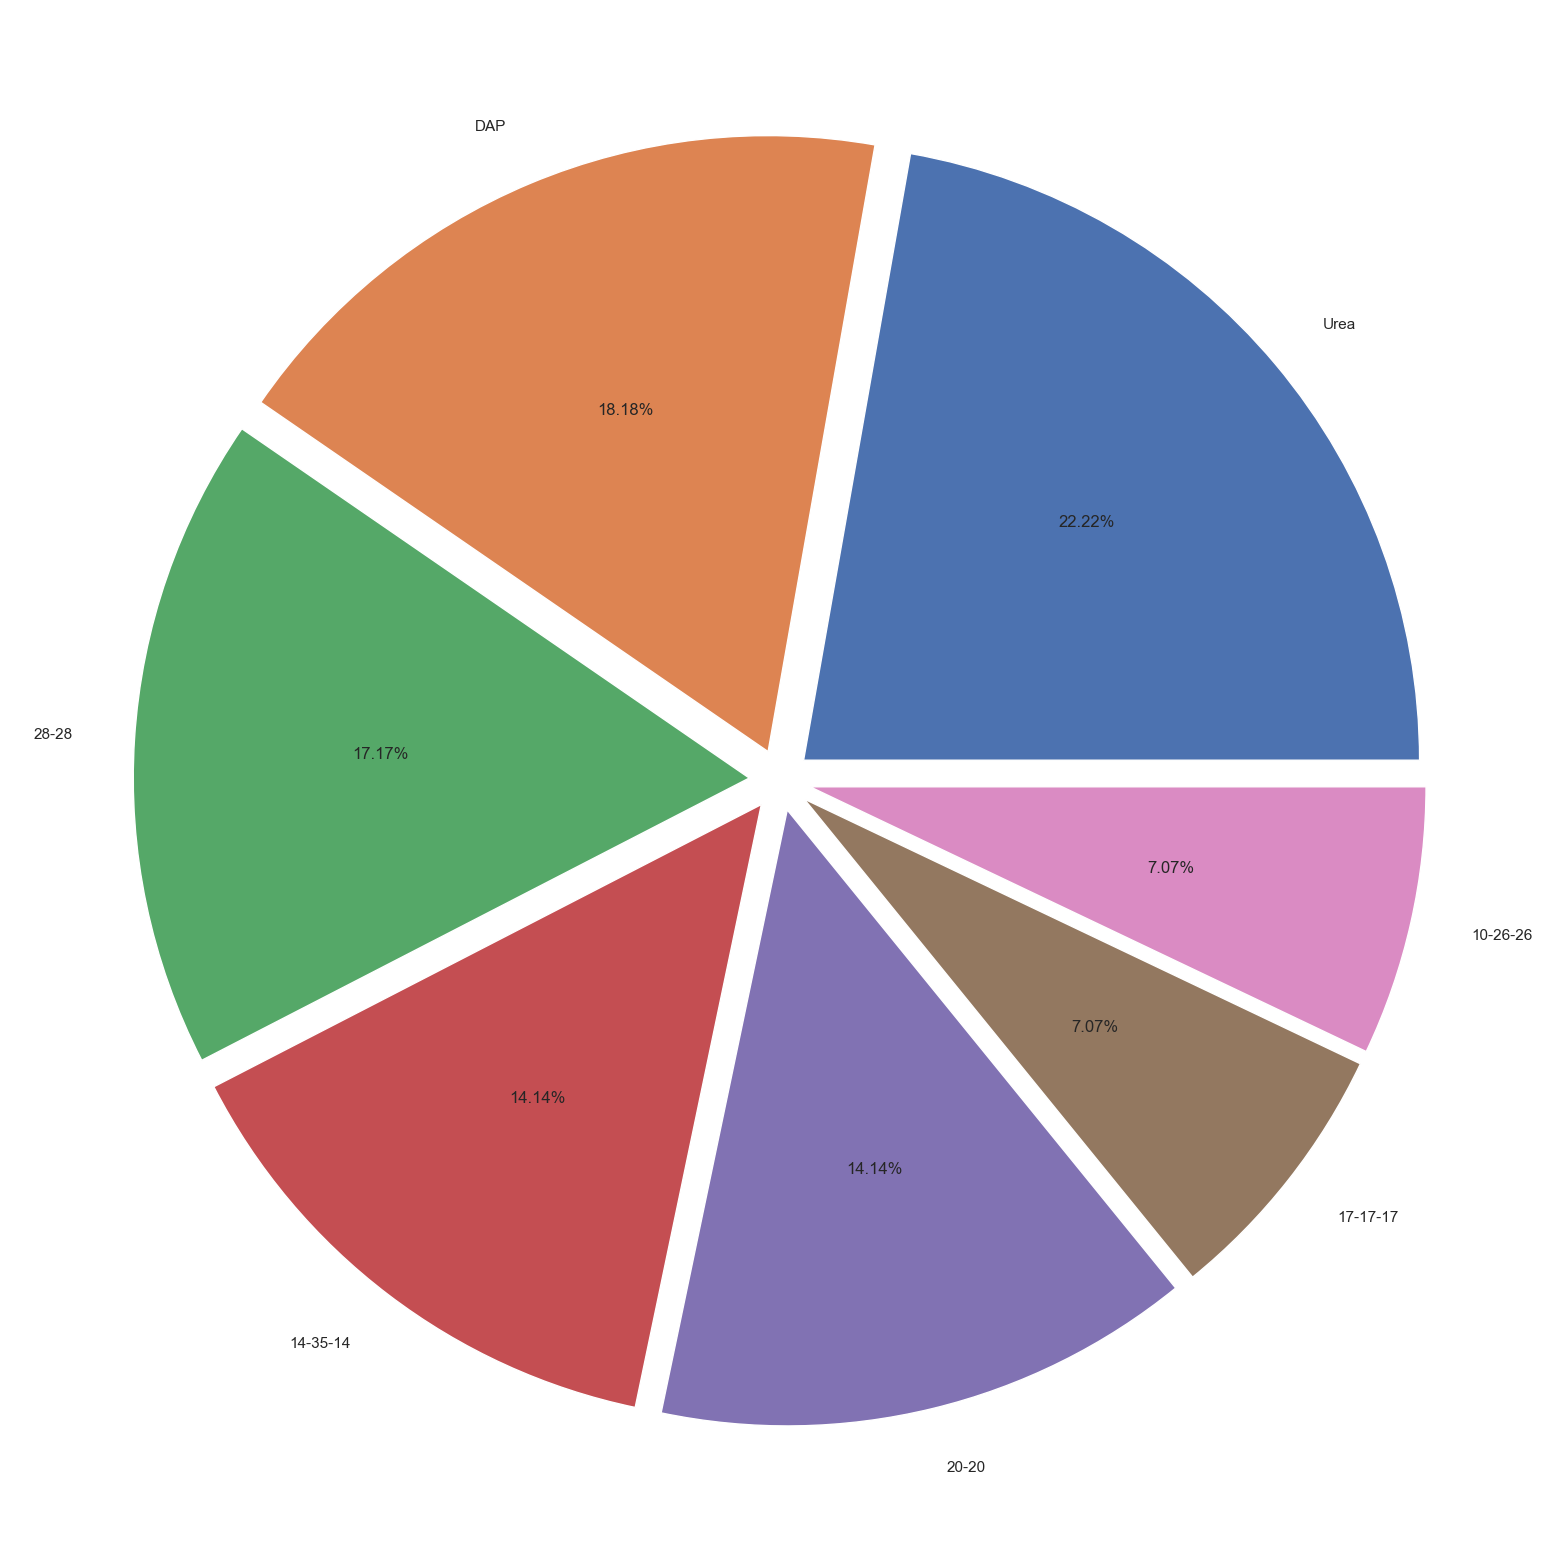

In [79]:
make_pie('Fertilizer Name')

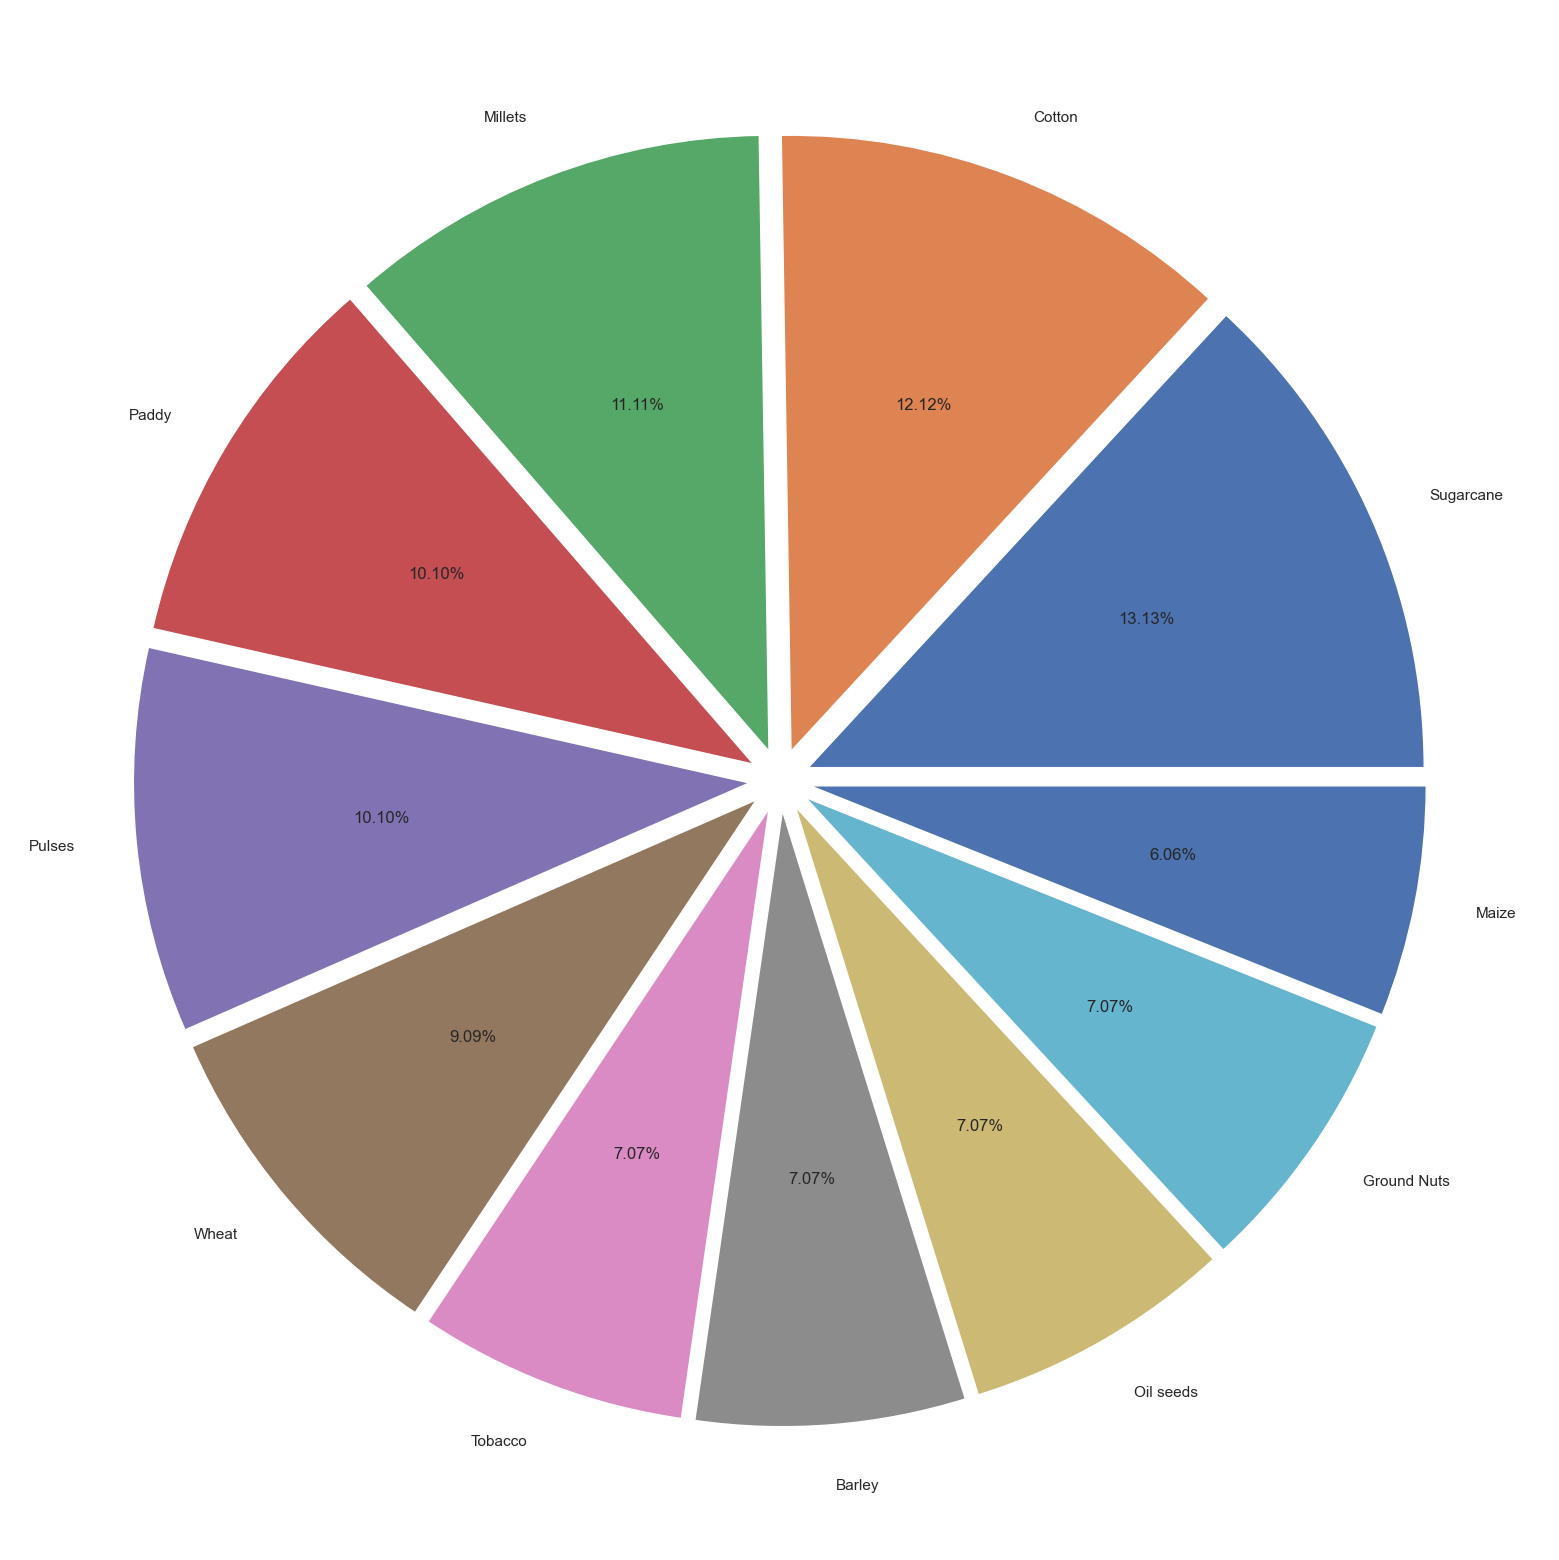

In [80]:
make_pie('Crop Type')

## Data engineering

In [81]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99 entries, 0 to 98
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Temparature      99 non-null     int64 
 1   Humidity         99 non-null     int64 
 2   Moisture         99 non-null     int64 
 3   Soil Type        99 non-null     object
 4   Crop Type        99 non-null     object
 5   Nitrogen         99 non-null     int64 
 6   Potassium        99 non-null     int64 
 7   Phosphorous      99 non-null     int64 
 8   Fertilizer Name  99 non-null     object
dtypes: int64(6), object(3)
memory usage: 7.1+ KB


In [82]:
def make_label_encoder(original_feature , new_feature) : 
    enc  = LabelEncoder()
    enc.fit(data[original_feature])
    data[new_feature] = enc.transform(data[original_feature])
    data.drop([original_feature],axis=1, inplace=True)
    enc_type = pd.DataFrame(zip(enc.classes_,enc.transform(enc.classes_)),columns=['Original','Encoded'])
    enc_type.set_index('Original')
    print(enc_type)

In [83]:
make_label_encoder('Soil Type','Soil_Code')

  Original  Encoded
0    Black        0
1   Clayey        1
2    Loamy        2
3      Red        3
4    Sandy        4


In [84]:
make_label_encoder('Crop Type','Crop_Code')

       Original  Encoded
0        Barley        0
1        Cotton        1
2   Ground Nuts        2
3         Maize        3
4       Millets        4
5     Oil seeds        5
6         Paddy        6
7        Pulses        7
8     Sugarcane        8
9       Tobacco        9
10        Wheat       10


In [85]:
make_label_encoder('Fertilizer Name','Fertilizer_Code')

   Original  Encoded
0  10-26-26        0
1  14-35-14        1
2  17-17-17        2
3     20-20        3
4     28-28        4
5       DAP        5
6      Urea        6


## Model

In [86]:
train_main = data.drop('Fertilizer_Code', axis=1).copy()
target = data['Fertilizer_Code'].copy()

In [87]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(train_main, target, train_size=0.7, shuffle=True, random_state=42)

In [88]:
train_col = X_train.columns
test_col = X_test.columns

In [89]:
from sklearn.preprocessing import MinMaxScaler
ms = MinMaxScaler()
X_train = ms.fit_transform(X_train)
X_test = ms.transform(X_test)

In [90]:
X_train = pd.DataFrame(X_train, columns=[train_col])
X_test = pd.DataFrame(X_test, columns=[test_col])

In [91]:
X_train.head()

,Temparature,Humidity,Moisture,Nitrogen,Potassium,Phosphorous,Soil_Code,Crop_Code
0,0.000000,0.000000,0.175,0.527778,0.000000,0.452381,0.25,0.7
1,0.307692,0.363636,0.375,0.527778,0.000000,0.547619,0.75,0.2
2,0.923077,0.909091,0.175,0.194444,0.000000,0.928571,0.00,0.5
3,0.307692,0.363636,0.900,0.166667,0.000000,0.904762,0.50,0.1
4,0.076923,0.090909,0.250,0.194444,0.526316,0.309524,1.00,0.0


In [92]:
from sklearn.ensemble import RandomForestClassifier
classifier = RandomForestClassifier(n_estimators= 100, criterion = 'gini' , random_state= 42)
classifier.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [93]:
with open('random_forest_model.pkl', 'wb') as f:
    pickle.dump(classifier, f)

In [94]:
y_pred = classifier.predict(X_test)

In [95]:
from sklearn.metrics import confusion_matrix,classification_report, accuracy_score

accuracy_score(y_test, y_pred)

0.9666666666666667

In [96]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.75      1.00      0.86         3
           1       1.00      1.00      1.00         4
           2       1.00      0.50      0.67         2
           3       1.00      1.00      1.00         1
           4       1.00      1.00      1.00         6
           5       1.00      1.00      1.00         7
           6       1.00      1.00      1.00         7

    accuracy                           0.97        30
   macro avg       0.96      0.93      0.93        30
weighted avg       0.97      0.97      0.96        30

